In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats
sns.set_style("darkgrid")
set_matplotlib_formats('retina')
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)
sns.set_palette("deep")

In [2]:
data = pd.read_csv("data/train.csv")

In [3]:
data.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


- different column : '공급유형','전용면적','전용면적별세대수','자격유형','임대보증금','임대료'
- same column : '단지코드','총세대수','지역','공가수','지하철역','버스정류장','단지내주차면수','등록차량수'

In [4]:
data.shape

(2952, 15)

In [5]:
print('단지코드 수: ',data.groupby('단지코드').count().shape[0])

단지코드 수:  423


In [6]:
data = data.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철역','도보 10분거리 내 버스정류장 수':'버스정류장'})

In [7]:
data.isna().sum() #	C1925

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철역        211
버스정류장         4
단지내주차면수       0
등록차량수         0
dtype: int64

## 버스정류장

In [8]:
data[data['버스정류장'].isna()==True]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수
2315,C1649,575,아파트,경상남도,공공임대(10년),74.97,80,15.0,A,46000000,456000,NaN,NaN,1066.0,855.0
2316,C1649,575,아파트,경상남도,공공임대(10년),84.95,124,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0
2317,C1649,575,아파트,경상남도,공공임대(10년),84.96,289,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0
2318,C1649,575,아파트,경상남도,공공임대(10년),84.98,82,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0


In [9]:
data[data['지역']=='경상남도']['버스정류장'].mean()

3.824657534246575

In [10]:
ind = data[data['버스정류장'].isna()==True].index
data.loc[ind,'버스정류장']=4

## 지하철역

In [11]:
data[data['지하철역'].isna()==True]['지역'].unique()

for i in data[data['지하철역'].isna()==True]['지역'].unique():
    print(i,data[(data['지역']==i)]['지하철역'].unique())

ind = data[(data['지역']=='충청남도')&(data['지하철역'].isna()==True)].index
data.loc[ind,'지하철역'] = 0

ind = data[(data['지역']=='경상남도')&(data['지하철역'].isna()==True)].index
data.loc[ind,'지하철역'] = 0

data[data['지역']=='대전광역시'].corr()['지하철역']

X_train = data[(data['지역']=='대전광역시')&(data['지하철역'].isna()==False)]['버스정류장'].values.reshape(-1,1)
y_train = data[(data['지역']=='대전광역시')&(data['지하철역'].isna()==False)]['지하철역'].values.ravel()
X_test = data[(data['지역']=='대전광역시')&(data['지하철역'].isna()==True)]['버스정류장'].values.reshape(-1,1)

from sklearn.linear_model import LogisticRegression
reg = LogisticRegression().fit(X_train, y_train)
pred = reg.predict(X_test)

ind = data[(data['지역']=='대전광역시')&(data['지하철역'].isna()==True)].index
data.loc[ind,'지하철역'] = pred

충청남도 [nan  0.]
대전광역시 [ 1.  0. nan]
경상남도 [ 0. nan]


## 전용면적별세대수

In [12]:
train = data[['단지코드','총세대수','지역','공가수','지하철역','버스정류장','단지내주차면수','등록차량수']]
train = train.drop_duplicates()
# '공급유형','전용면적','전용면적별세대수','자격유형','임대보증금','임대료'

In [13]:
sample = pd.DataFrame(data.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()

In [14]:
for i in sample.공급유형.unique():
    train[str(i)]=0

In [15]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = train[train['단지코드']==code].index
    train.loc[ind,col] = val

## 임대건물구분

<AxesSubplot:xlabel='임대건물구분', ylabel='count'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


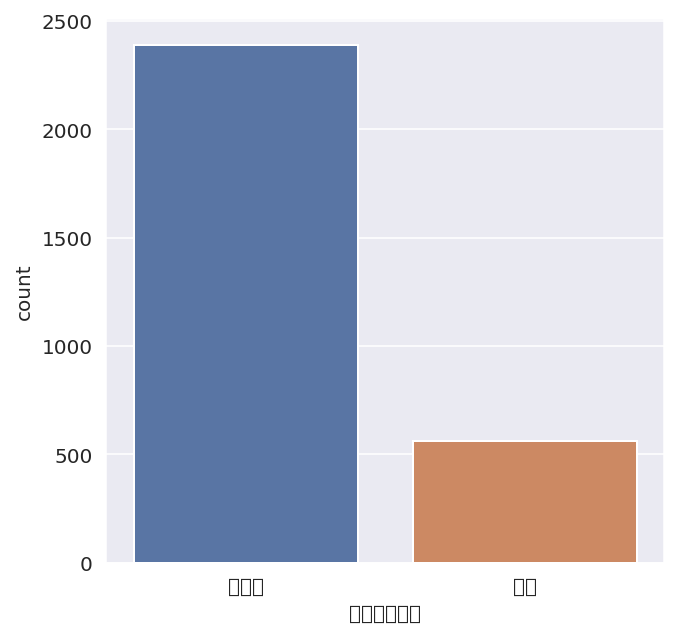

In [16]:
fig,ax = plt.subplots(figsize=(5,5))
sns.countplot(data=data,x='임대건물구분')

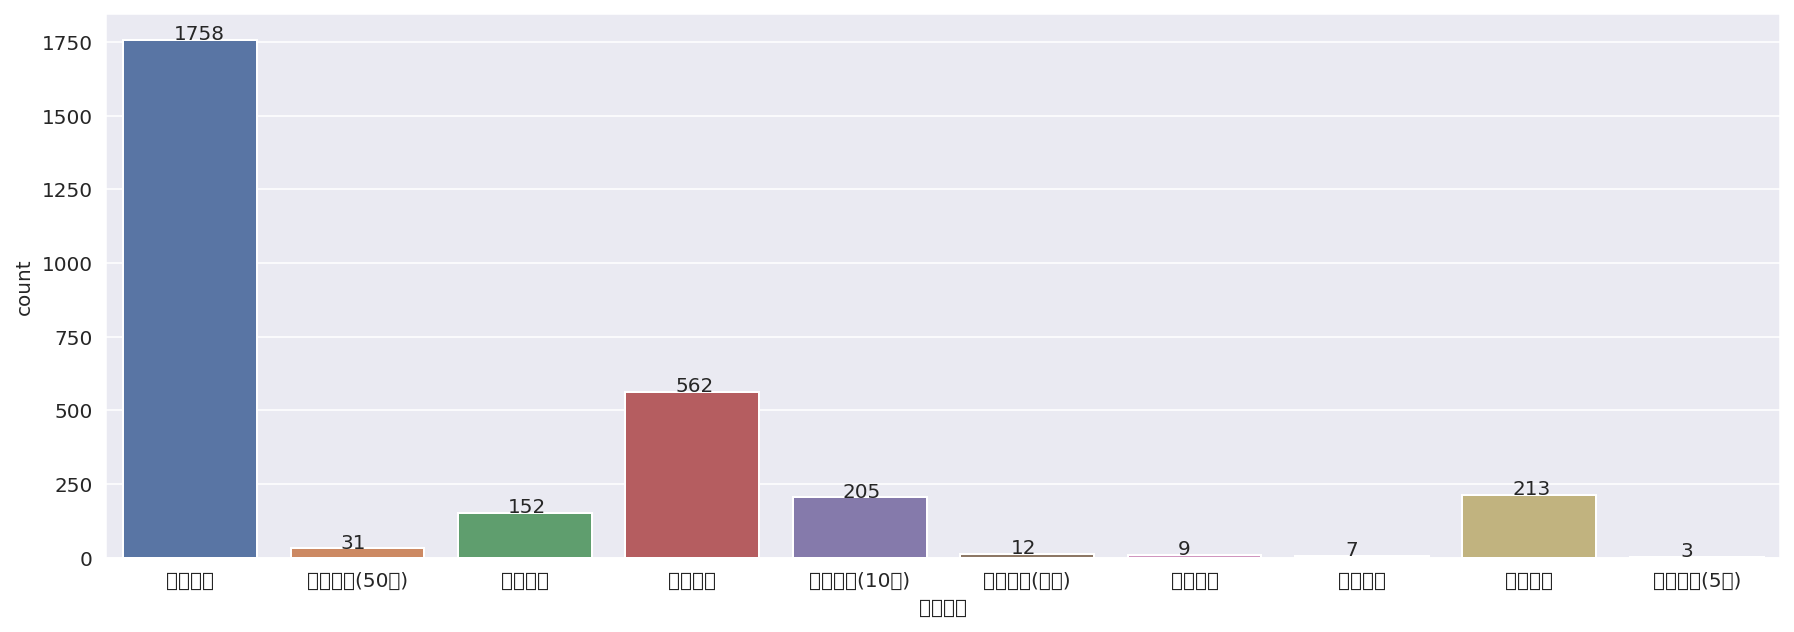

In [17]:
fig,ax = plt.subplots(figsize=(15,5))
sns.countplot(data=data,x='공급유형')
for p in ax.patches:
    ax.annotate(s=p.get_height(),xy=(p.get_xy()[0]+0.3,p.get_height()))

In [18]:
data[data['임대건물구분']=='상가']['공급유형'].unique()

array(['임대상가'], dtype=object)

## 임대료, 임대보증금

In [19]:
data['임대료'] = data['임대료'].replace('-',np.nan)
data['임대보증금'] = data['임대보증금'].replace('-',np.nan)

In [20]:
data['임대료'] = data['임대료'].apply(lambda x : float(x))
data['임대보증금'] = data['임대보증금'].apply(lambda x : float(x))

In [21]:
def get_values(code):
    df = data[(data['단지코드']==code)&(data['임대료'].isna()==False)]
    deposit = df['임대보증금'].values.mean()
    rent = df['임대료'].values.mean()
    return deposit,rent

- 임대료, 임대보증금이 NA값인 경우는 모두 상가
- 동일한 단지코드인 아파트 임대료, 임대보증금 평균 값을 사용해서 NA imputation
- 다른 외부 데이터를 이용해서 주상복합에 속한 아파트, 상가의 보증금 관계를 살펴보는 것도 하나의 방법일듯

In [22]:
code = data[data['임대료'].isna()==True]['단지코드'].unique()
for i in code:
    n = data[(data['단지코드']==i)&(data['임대료'].isna()==False)].shape[0]
    if n ==0 :
        print(i)
    if n != 0 :
        ind = data[(data['단지코드']==i)&(data['임대료'].isna()==True)].index
        data.loc[ind,'임대료'] = get_values(i)[1]

C1397
C1326


In [23]:
code = data[data['임대보증금'].isna()==True]['단지코드'].unique()
for i in code:
    n = data[(data['단지코드']==i)&(data['임대보증금'].isna()==False)].shape[0]
    if n== 0 :
        print(i)
    if n != 0 :
        ind = data[(data['단지코드']==i)&(data['임대보증금'].isna()==True)].index
        data.loc[ind,'임대보증금'] = get_values(i)[1]

C1326


- C1397

In [24]:
data[data['단지코드']=='C1397'][['지역','공급유형']].values[0]

array(['서울특별시', '장기전세'], dtype=object)

In [25]:
m = data[(data['지역']=='서울특별시')&(data['임대료'].isna()==False)]['임대료'].values.mean()

In [26]:
data.loc[data['단지코드']=='C1397','임대료'] = m

- C1326

In [27]:
data[data['단지코드']=='C1326'][['지역','공급유형']].values[0]

array(['부산광역시', '국민임대'], dtype=object)

In [28]:
m1 = data[(data['지역']=='부산광역시')&(data['공급유형']=='국민임대')&(data['임대료'].isna()==False)]['임대료'].values.mean()
m2 = data[(data['지역']=='부산광역시')&(data['공급유형']=='국민임대')&(data['임대보증금'].isna()==False)]['임대보증금'].values.mean()

In [29]:
data.loc[data['단지코드']=='C1326','임대료'] = m1
data.loc[data['단지코드']=='C1326','임대보증금'] = m2

## 임대료 임대보증금 2

In [30]:
sample = data.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,104695.000000,5.889376e+05
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [31]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = train[train['단지코드']==code].index
    train.loc[ind,'임대료'] = val1
    train.loc[ind,'임대보증금'] = val2

## 전용면적

<AxesSubplot:xlabel='전용면적', ylabel='Count'>

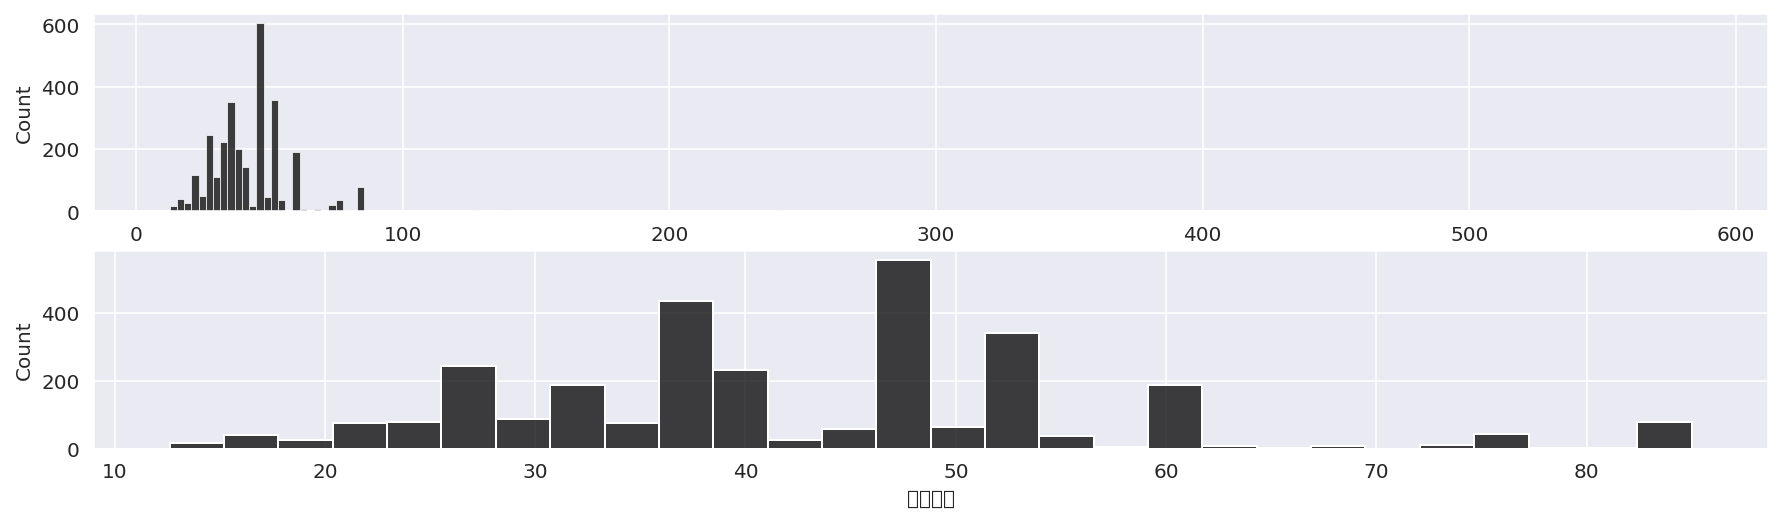

In [32]:
tmp = data[data['전용면적']<100]
fig,ax = plt.subplots(2,1,figsize=(15,4))
sns.histplot(data=data,x='전용면적',color='black',ax=ax[0])
sns.histplot(data=tmp,x='전용면적',color='black',ax=ax[1])

In [33]:
data[data['전용면적']<100].groupby('단지코드').std()['전용면적'].mean()

6.784126090920137

In [34]:
def category(x):
    for ind,i in enumerate(list(range(10,110,5))): #0부터 100까지 10단위
        if int(x) in range(i-10,i): return ind
    for ind,i in enumerate(list(range(100,600,100))):#100부터 600까지 100단위
        if int(x) in range(i,i+100): return 10+ind

In [35]:
data['전용면적 카테고리']  = data['전용면적'].apply(lambda x : category(x))

In [36]:
for i in data['전용면적 카테고리']:
    train['전용면적'+str(i)] = 0

In [37]:
sample = pd.DataFrame(data.groupby('단지코드')['전용면적 카테고리'].unique()).reset_index()
sample.head()

,단지코드,전용면적 카테고리
0,C1000,"[6, 8, 9]"
1,C1004,"[6, 2, 1, 3, 4, 5, 9, 11]"
2,C1005,"[9, 10]"
3,C1013,"[6, 8, 9]"
4,C1014,"[5, 8, 9, 10]"


In [38]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val = sample.loc[i,'전용면적 카테고리']
    ind = train[train['단지코드']==code].index
    for j in val:
        train.loc[ind,'전용면적'+str(j)] = 1

## 자격유형

In [39]:
for i in data['자격유형'].unique():
    print(i,data[data['자격유형']==i]['공급유형'].unique())

A ['국민임대' '공공임대(50년)' '공공임대(10년)' '공공임대(분납)' '장기전세' '영구임대' '공공임대(5년)']
B ['국민임대']
C ['영구임대']
D ['임대상가' '공공분양']
E ['영구임대' '국민임대']
F ['영구임대']
G ['국민임대']
H ['국민임대']
I ['영구임대']
J ['행복주택']
K ['행복주택']
L ['행복주택']
M ['행복주택']
N ['행복주택']
O ['행복주택']


- 14개 그룹

<AxesSubplot:xlabel='전용면적', ylabel='Density'>

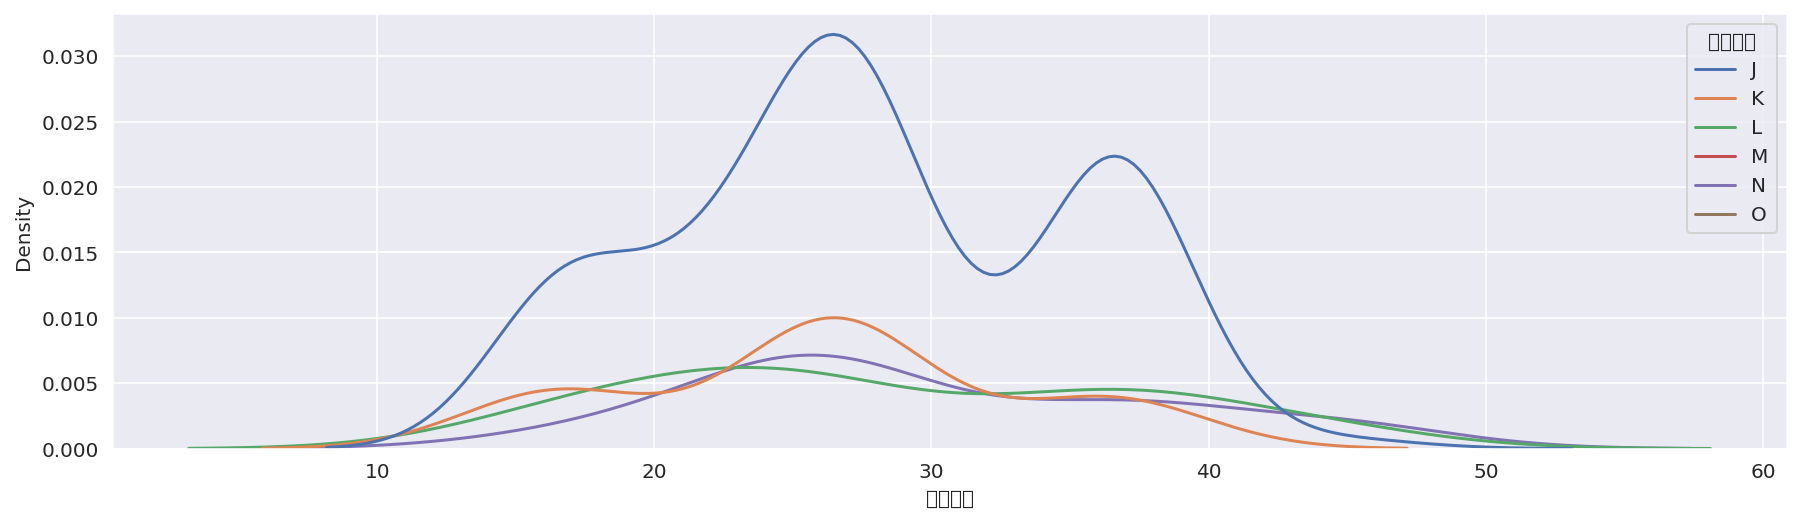

In [40]:
tmp = data[data['공급유형']=='행복주택']
fig,ax = plt.subplots(figsize=(15,4))
sns.kdeplot(data=tmp,x='전용면적',color='black',hue='자격유형')

- J / K L M N O

<AxesSubplot:xlabel='전용면적', ylabel='Density'>

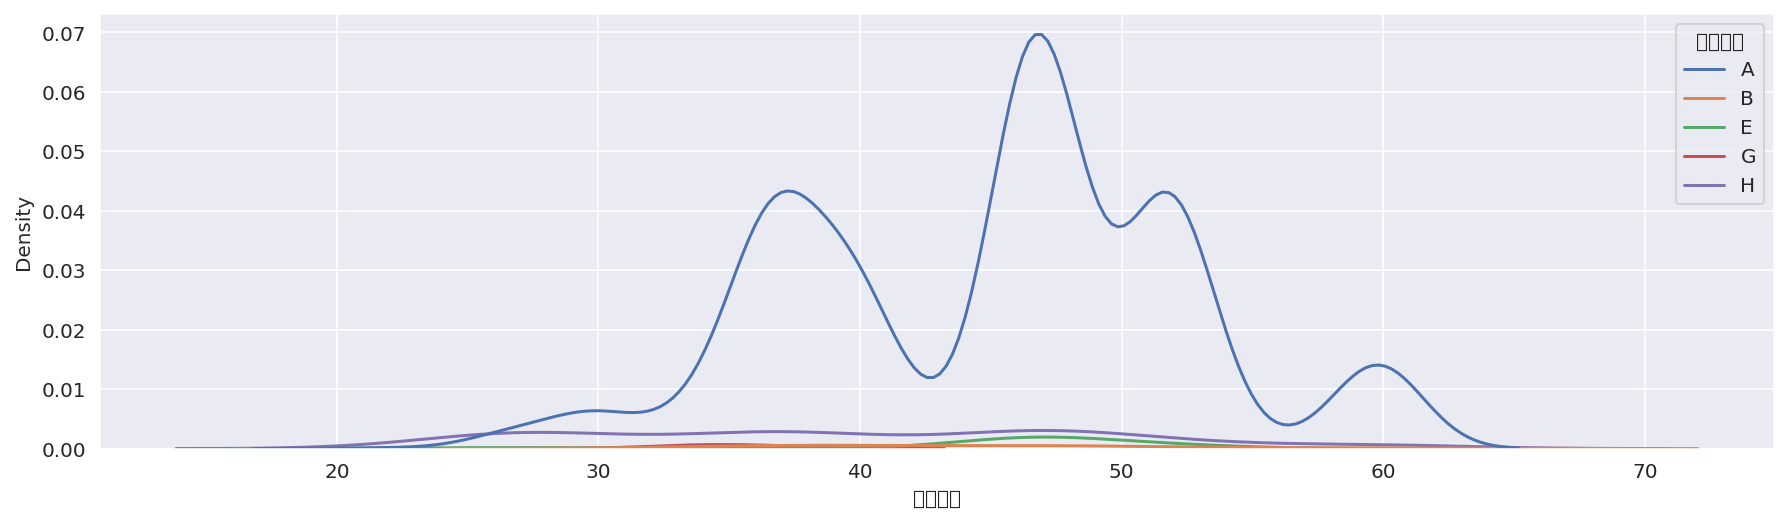

In [41]:
tmp = data[data['공급유형']=='국민임대']
fig,ax = plt.subplots(figsize=(15,4))
sns.kdeplot(data=tmp,x='전용면적',color='black',hue='자격유형')

- A / B E G H

<AxesSubplot:xlabel='전용면적', ylabel='Density'>

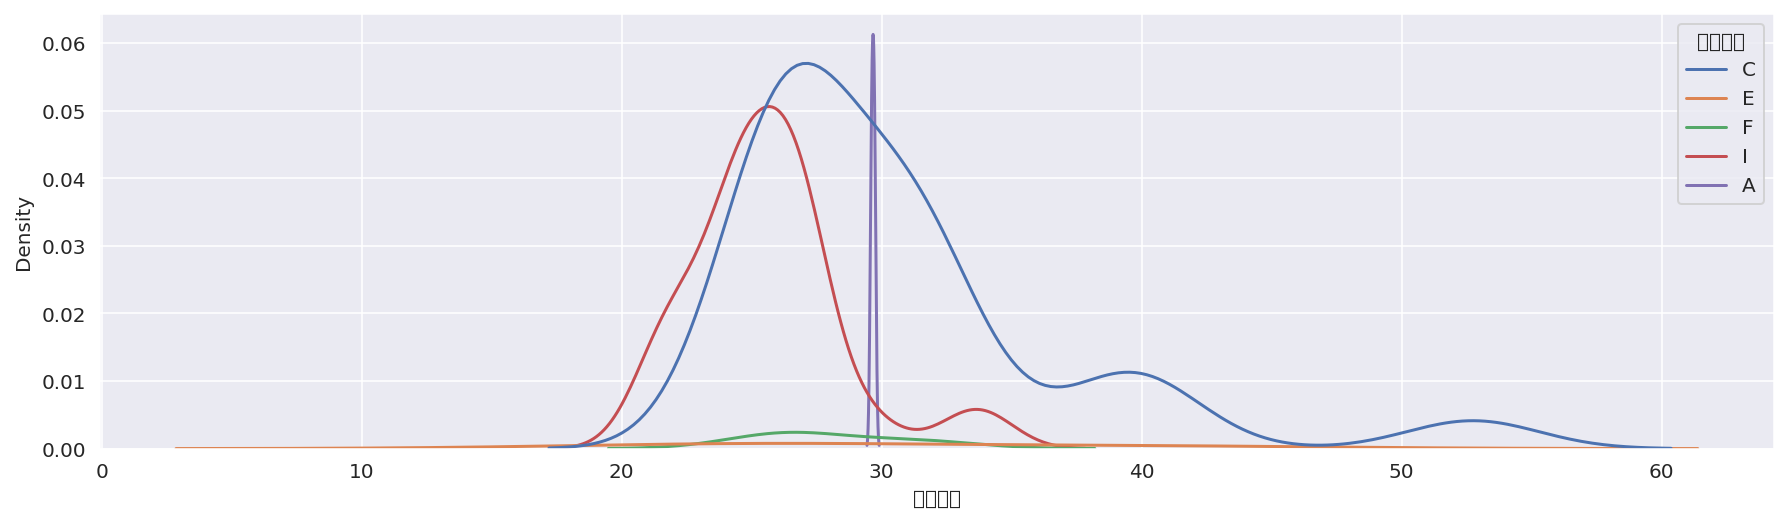

In [42]:
tmp = data[data['공급유형']=='영구임대']
fig,ax = plt.subplots(figsize=(15,4))
sns.kdeplot(data=tmp,x='전용면적',color='black',hue='자격유형')

- C / I / A / E F

In [43]:
# J / K L M N O / A / B E G H / C / I / E F 

In [44]:
dic = {'1': 'A' ,'2':['B','E','G','H'],'3':['E','F'],'4':'I','5':['K','L','M','N','O'],'6':'J','7':'C','8':'D'}

In [45]:
def category2(x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [46]:
data['자격유형 카테고리'] = data['자격유형'].apply(lambda x : category2(x))

In [47]:
sample = pd.DataFrame(data.groupby('단지코드')['자격유형 카테고리'].unique()).reset_index()
sample.head()

,단지코드,자격유형 카테고리
0,C1000,[1]
1,C1004,"[7, 8]"
2,C1005,[1]
3,C1013,[1]
4,C1014,[1]


In [48]:
for i in dic.keys():
    train['자격유형'+str(i)]=0

In [49]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val = sample.loc[i,'자격유형 카테고리']
    ind = train[train['단지코드']==code].index
    for j in val:
        train.loc[ind,'자격유형'+str(j)] = 1

## 지역 별 인구수

In [113]:
data3 = pd.read_csv("data/age_gender_info.csv")
data3.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [116]:
data3['지역'].unique()

array(['경상북도', '경상남도', '대전광역시', '경기도', '전라북도', '강원도', '광주광역시', '충청남도',
       '부산광역시', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '대구광역시', '서울특별시',
       '세종특별자치시'], dtype=object)

In [99]:
tmp = data3[['지역','20대(여자)','30대(여자)','40대(여자)','50대(여자)','60대(여자)','20대(남자)','30대(남자)','40대(남자)','50대(남자)','60대(남자)']]

In [103]:
train = pd.merge(train,tmp,how='left',on='지역')

In [104]:
train.to_csv("data/trainsample.csv",index=False)

# Test Data

In [51]:
data2 = pd.read_csv("data/test.csv")

In [52]:
data2.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [53]:
data2 = data2.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철역','도보 10분거리 내 버스정류장 수':'버스정류장'})

In [54]:
data2.shape

(1022, 14)

In [55]:
data2.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철역         42
버스정류장         0
단지내주차면수       0
dtype: int64

## NA 처리

### 1) 지하철 수

In [56]:
data2[data2['지하철역'].isna()==True]['지역'].unique()

array(['충청남도', '대전광역시'], dtype=object)

In [57]:
ind = data2[(data2['지역']=='충청남도')&(data2['지하철역'].isna()==True)].index
data2.loc[ind,'지하철역'] = 0

In [58]:
X_test = data2[(data2['지역']=='대전광역시')&(data2['지하철역'].isna()==True)]['버스정류장'].values.reshape(-1,1)
pred = reg.predict(X_test)

In [59]:
ind = data2[(data2['지역']=='대전광역시')&(data2['지하철역'].isna()==True)].index
data2.loc[ind,'지하철역'] = 0

### 2) 자격유형

In [60]:
tmp = data2[data2['자격유형'].isna()==True]['단지코드'].values # A C로 채우기

In [61]:
ind = data2[(data2['자격유형'].isna()==True)].index
data2.loc[ind[0],'자격유형'] = 'A'
data2.loc[ind[1],'자격유형'] = 'C'

### 3) 임대료, 임대보증금

In [62]:
data2['임대료'] = data2['임대료'].replace('-',np.nan)
data2['임대보증금'] = data2['임대보증금'].replace('-',np.nan)

In [63]:
data2['임대료'] = data2['임대료'].apply(lambda x : float(x))
data2['임대보증금'] = data2['임대보증금'].apply(lambda x : float(x))

In [64]:
def get_values(code):
    df = data2[(data2['단지코드']==code)&(data2['임대료'].isna()==False)]
    deposit = df['임대보증금'].values.mean()
    rent = df['임대료'].values.mean()
    return deposit,rent

In [65]:
code = data2[data2['임대료'].isna()==True]['단지코드'].unique()
for i in code:
    n = data2[(data2['단지코드']==i)&(data2['임대료'].isna()==False)].shape[0]
    if n ==0 :
        print(i)
    if n != 0 :
        ind = data2[(data2['단지코드']==i)&(data2['임대료'].isna()==True)].index
        data2.loc[ind,'임대료'] = get_values(i)[1]

C2152


In [66]:
code = data2[data2['임대보증금'].isna()==True]['단지코드'].unique()
for i in code:
    n = data2[(data2['단지코드']==i)&(data2['임대보증금'].isna()==False)].shape[0]
    if n== 0 :
        print(i)
    if n != 0 :
        ind = data2[(data2['단지코드']==i)&(data2['임대보증금'].isna()==True)].index
        data2.loc[ind,'임대보증금'] = get_values(i)[1]

C2152


In [67]:
ind = data2[data2['임대보증금'].isna()==True].index

- 강원도, 영구임대 아파트 중에서 전용면적이 비슷한 값으로 imputation
- 첫번째 case 7569000.0	73100.0
- 두번째 case 5009000.0	93000.0	

In [68]:
data2.loc[ind[0],['임대보증금','임대료']] = [7569000.0, 73100.0]
data2.loc[ind[1],['임대보증금','임대료']] = [5009000.0, 93000.0]

In [69]:
test = data2[['단지코드','총세대수','지역','공가수','지하철역','버스정류장','단지내주차면수']]
test = test.drop_duplicates()

In [70]:
test.shape

(150, 7)

## 임대료, 임대보증금

In [71]:
''''''
sample = data2.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,115875.000000,2.265000e+07
1,C1006,83732.500000,9.688832e+05
2,C1016,228010.000000,2.402675e+07
3,C1019,126430.000000,1.485750e+07
4,C1030,214216.666667,5.141333e+07


In [72]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = test[test['단지코드']==code].index
    test.loc[ind,'임대료'] = val1
    test.loc[ind,'임대보증금'] = val2

## 전용면적별세대수

In [73]:
sample = pd.DataFrame(data2.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1485
2,C1006,임대상가,20
3,C1016,국민임대,643
4,C1019,국민임대,321


In [74]:
print('test data 공급유형 종류: ',data2.공급유형.nunique()) 
print('train data 공급유형 종류: ',data.공급유형.nunique()) 

test data 공급유형 종류:  7
train data 공급유형 종류:  10


In [75]:
print(data.공급유형.unique())
print(data2.공급유형.unique())

['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '공공임대(분납)' '장기전세' '공공분양'
 '행복주택' '공공임대(5년)']
['국민임대' '영구임대' '임대상가' '공공임대(50년)' '공공임대(10년)' '공공임대(분납)' '행복주택']


In [76]:
for i in data.공급유형.unique():
    test[str(i)]=0

In [77]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = test[test['단지코드']==code].index
    test.loc[ind,col] = val

## 전용면적

In [78]:
data2['전용면적 카테고리']  = data2['전용면적'].apply(lambda x : category(x))

In [79]:
for i in data2['전용면적 카테고리']:
    test['전용면적'+str(i)] = 0

In [80]:
sample = pd.DataFrame(data2.groupby('단지코드')['전용면적 카테고리'].unique()).reset_index()
sample.head()

,단지코드,전용면적 카테고리
0,C1003,"[2, 4, 6, 7]"
1,C1006,"[4, 5, 9, 6, 14]"
2,C1016,"[6, 8, 10]"
3,C1019,"[6, 8]"
4,C1030,"[2, 4, 6]"


In [81]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val = sample.loc[i,'전용면적 카테고리']
    ind = test[test['단지코드']==code].index
    for j in val:
        test.loc[ind,'전용면적'+str(j)] = 1

## 자격유형

In [82]:
data2['자격유형 카테고리'] = data2['자격유형'].apply(lambda x : category2(x))

In [83]:
sample = pd.DataFrame(data2.groupby('단지코드')['자격유형 카테고리'].unique()).reset_index()
sample.head()

,단지코드,자격유형 카테고리
0,C1003,[6]
1,C1006,"[7, 8]"
2,C1016,[1]
3,C1019,[1]
4,C1030,[6]


In [84]:
for i in dic.keys():
    test['자격유형'+str(i)]=0

In [85]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val = sample.loc[i,'자격유형 카테고리']
    ind = test[test['단지코드']==code].index
    for j in val:
        test.loc[ind,'자격유형'+str(j)] = 1

In [107]:
print(train.shape)
print(test.shape)

(423, 53)
(150, 52)


## 지역 별 인구

In [106]:
test = pd.merge(test,tmp,how='left',on='지역')

In [111]:
test.to_csv("data/testsample.csv",index=False)

# Sample submission

In [108]:
data3 = pd.read_csv("data/sample_submission.csv")

In [109]:
data3.head()

,code,num
0,C1072,585.0
1,C1128,1015.0
2,C1456,700.0
3,C1840,646.0
4,C1332,708.0


In [110]:
data3.shape

(150, 2)